## Interlude - Statistics of Altman features

In this notebook, we will collect some useful statistics of the Altman features. The dataset in full contains > 4,000,000,000 vectors (4 billions!). Statistics has to be collected with incremental methods. While the statistics to standardise the vectors had been done and stored as `Feature.IPCA.altman.AUCG.pkl`, we will take a look (a glimpse) into the cross correlation among the Altman features and comment on some of their properties. The purpose of this notebook is to [get basic understanding of our data](https://ai.googleblog.com/2021/08/a-dataset-exploration-case-study-with.html) as the first step in building a machine learning pipeline.

## Imports

In [1]:
# ============== Imports
import sys
import glob
import tqdm 

import pandas as pd
import numpy as np

from scipy import sparse

import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append('../')


%config InlineBackend.figure_format = 'svg'
sns.set_context("notebook")


from NucleicNet.DatasetBuilding.util import *
from NucleicNet.DatasetBuilding.commandHalo import Halo
from NucleicNet.DatasetBuilding.commandFeaturisation import Featurisation
from NucleicNet.DatasetBuilding.commandReadPdbFtp import ReadBCExternalSymmetry, MakeBcClanGraph
from NucleicNet.DatasetBuilding.commandDataFetcher import FetchIndex, FetchTask, FetchDataset

from sklearn.preprocessing import StandardScaler
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
import random
random.seed(0)
import pickle
import random


feature_avail = sorted(glob.glob("../Database-PDB/feature/*.npz"))
# NOTE This counter the effect that early pdbid historically named as 1*** 
#      are usually in small size some with parts that are less than 20 angstrom in diameter, giving a rough time for convergence.
random.seed(0)
random.shuffle(feature_avail) 

feature_standiser = StandardScaler(with_mean=False, with_std=True, copy=False)



In [2]:



# ================ Collapse. Click Please 

User_DesiredBatchDatasize    = 70000000 # NOTE This controls the number of new batch of dataset-dataloader being reloaded into memory
User_SampleSizePerEpoch_Factor = 1.0 # NOTE This controls how much sample enters into an epoch. if < 1.0, the sampler will make less than User_DesiredBatchDatasize sample to be fed in one epoch

User_SampleSizePerEpoch = int(User_DesiredBatchDatasize * User_SampleSizePerEpoch_Factor)
n_datasetworker = 16
User_ExperiementName = 'AUCG-9CV'

User_SelectedCrossFoldIndex = 0


# TODO For SXPR the selection of pdb has to be separated less stringent than AUCG

# ================= Click Please. Directories ==================
DIR_DerivedData = "../Database-PDB/DerivedData/"
DIR_Typi = "../Database-PDB/typi/"
DIR_FuelInput = "../Database-PDB/feature/"

n_CrossFold = 9
ClanGraphBcPercent = 90
User_featuretype = 'altman'
User_Task = "AUCG"
n_row_maxhold = 10000


Df_grand = pd.read_pickle(DIR_DerivedData + "/DataframeGrand.pkl")
Df_grand = Df_grand.loc[(Df_grand["ProNu"] == "prot-nuc") & (Df_grand['Resolution'] <= 3.5) # NOTE you may consider to relax the 3.0 Angstron resolution limit as cryoEM structure w/ ~3.5 angstrom are not uncommon to be modelled in full atom these days
                                          & ~(Df_grand['PubmedID'].isnull()) # NOTE ~78 structures. Note that some are recent unindexed by pdb; most are unpublished structures. Some contains large missing loops.
                                          & (Df_grand['NucleicAcid'].isin(['rna']))
                                          & (pd.notnull(Df_grand['InternalSymmetryBC-95']))
                                          & (Df_grand["Year"] <= 2021)
                                          & (Df_grand["MeanChainLength_Nucleotide"] >= 4) & (Df_grand["SumChainLength_Peptide"] > 50) 
                                          # NOTE Some machineries that do not show preference in base or a disproportionately small amount of sites with preference.
                                          & ~(Df_grand["Title"].str.contains('ribos|trna', regex=True, na=False)) 
                                          & ~(Df_grand["Header"].str.contains('ribos|trna', regex=True, na=False))
                                          & ~(Df_grand['NpidbClassification'].isin(["TRANSFERASE/RNA",'TRANSFERASE','RIBOSOME'])) # ~170 structures
                                              ]






FetchTaskC = FetchTask(DIR_DerivedData = DIR_DerivedData,
                              DIR_Typi = DIR_Typi,
                              DIR_FuelInput = DIR_FuelInput,
                              Df_grand = Df_grand,
                              TaskNameLabelLogicDict = None,
                              n_row_maxhold = n_row_maxhold)

# =========================
# Get Definition of Tasks
# =========================
# NOTE This collects task name and how to get corresponding data in typi 
TaskNameLabelLogicDict = FetchTaskC.Return_TaskNameLabelLogicDict()
#print(TaskNameLabelLogicDict)


print(FetchTaskC.TaskNameLabelLogicDict)

# =======================
# Task Clan Fold Dataframe
# ======================= 
# NOTE each element contains 3 tuple train val test
CrossFoldDfList = FetchTaskC.Return_CrossFoldDfList(n_CrossFold = n_CrossFold, 
                                                      ClanGraphBcPercent = ClanGraphBcPercent, 
                                                      User_Task = User_Task,
                                                      Factor_ClampOnMaxSize = 450000,  # NOTE Constraint on datasize of a clan. For SXPR, this is raised as the number of datapoint per entry is much larger.
                                                      Factor_ClampOnMultistate = 20,   # NOTE Constriant on number of multistate file read
                                                      NmrStates = []
                                                      )

{'SXPR': {'Base': {'union': ['A', 'U', 'C', 'G'], 'exclu': [], 'intersect': []}, 'Nonsite': {'union': ['nonsite_'], 'exclu': ['F'], 'intersect': []}, 'P': {'union': ['P'], 'exclu': [], 'intersect': []}, 'R': {'union': ['R'], 'exclu': [], 'intersect': []}}, 'AUCG': {'A': {'union': ['A'], 'exclu': [], 'intersect': ['nucsite_']}, 'U': {'union': ['U'], 'exclu': [], 'intersect': ['nucsite_']}, 'C': {'union': ['C'], 'exclu': [], 'intersect': ['nucsite_']}, 'G': {'union': ['G'], 'exclu': [], 'intersect': ['nucsite_']}}}


In [4]:





FetchDatasetC = FetchDataset(
        DIR_DerivedData = DIR_DerivedData,
        DIR_Typi = DIR_Typi,
        DIR_FuelInput = DIR_FuelInput,

        User_DesiredDatasize    = User_DesiredBatchDatasize, # NOTE This controls the number of new batch of dataset-dataloader being reloaded into memory
        User_SampleSizePerEpoch_Factor = 1.0, # NOTE This controls how much sample enters into an epoch
        User_featuretype = User_featuretype,
        n_datasetworker = 16,
        ClanGraphBcPercent = ClanGraphBcPercent)
# =========================
# Get Definition of Tasks
# =========================
# NOTE This collects task name and how to get corresponding data in typi 
TaskNameLabelLogicDict = FetchTaskC.Return_TaskNameLabelLogicDict()
#print(TaskNameLabelLogicDict)


print(FetchTaskC.TaskNameLabelLogicDict)


# NOTE Pdbids, Datasize weight
Train_PdbidBatches, TrainFold_PdbidSamplingWeight = CrossFoldDfList[User_SelectedCrossFoldIndex][0]
Val_PdbidBatches, ValFold_PdbidSamplingWeight = CrossFoldDfList[User_SelectedCrossFoldIndex][1]
Testing_PdbidBatches,TestingFold_PdbidSamplingWeight  = CrossFoldDfList[User_SelectedCrossFoldIndex][2]
TrainVal_PdbidBatches  = Testing_PdbidBatches + Train_PdbidBatches + Val_PdbidBatches
TrainVal_PdbidSamplingWeight = pd.concat([TestingFold_PdbidSamplingWeight, TrainFold_PdbidSamplingWeight, ValFold_PdbidSamplingWeight])




{'SXPR': {'Base': {'union': ['A', 'U', 'C', 'G'], 'exclu': [], 'intersect': []}, 'Nonsite': {'union': ['nonsite_'], 'exclu': ['F'], 'intersect': []}, 'P': {'union': ['P'], 'exclu': [], 'intersect': []}, 'R': {'union': ['R'], 'exclu': [], 'intersect': []}}, 'AUCG': {'A': {'union': ['A'], 'exclu': [], 'intersect': ['nucsite_']}, 'U': {'union': ['U'], 'exclu': [], 'intersect': ['nucsite_']}, 'C': {'union': ['C'], 'exclu': [], 'intersect': ['nucsite_']}, 'G': {'union': ['G'], 'exclu': [], 'intersect': ['nucsite_']}}}


"\n# =========================================\n# Sampling weight  for each class NOTE Not in use because fold spitting will ruin the ratio...\n# ====================================\nSamplingWeightDf = FetchTaskC.Return_SamplingWeightDf(n_CrossFold = n_CrossFold, \n                                                      ClanGraphBcPercent = ClanGraphBcPercent, \n                                                      User_Task = User_Task)\nSamplingWeightDf = SamplingWeightDf.sort_values(by=['Class Index'], ignore_index= True)\nsampling_weight = SamplingWeightDf['Sampling Weight'].tolist()\n#print(1/SamplingWeightDf['Sampling Weight'])\nsampling_weight = (np.array(sampling_weight)/np.sum(sampling_weight)).tolist()\nsampling_weight = torch.tensor(sampling_weight)\n"

## Statistics

We will now examine relations among the Altman features. We will use [Sklearn's implementation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html) of [an Incremental PCA algorithm](https://www.cs.toronto.edu/~dross/ivt/RossLimLinYang_ijcv.pdf) to extract a basis of our features; these basis will allow dimensionality reduction and estimate the cross correlation among different Altman features. The input for the PCA is class balanced. While the features are expected to be sparse, this gives us opportunity to check on those features that are unused (constantly zero) and interesting ones that have large variance. This can complete within ~2 hours. 


In [10]:

classindex_str = sorted(TaskNameLabelLogicDict[User_Task].keys()) 
ClassName_ClassIndex_Dict = dict(zip(classindex_str, range(len(classindex_str))))

print("Getting TrainValTest batches")
PART1A_GetCrossFolds = True
if PART1A_GetCrossFolds:

    # NOTE Pdbids, Datasize weight
    
    Train_PdbidBatches, TrainFold_PdbidSamplingWeight = CrossFoldDfList[User_SelectedCrossFoldIndex][0]
    Val_PdbidBatches, ValFold_PdbidSamplingWeight = CrossFoldDfList[User_SelectedCrossFoldIndex][1]
    Testing_PdbidBatches,TestingFold_PdbidSamplingWeight  = CrossFoldDfList[User_SelectedCrossFoldIndex][2]

    print(len(Train_PdbidBatches), len(Val_PdbidBatches), len(Testing_PdbidBatches), len(set(Testing_PdbidBatches+Val_PdbidBatches+Train_PdbidBatches)))
    Train_PdbidWeight = dict(
            TrainFold_PdbidSamplingWeight[["Pdbid", "PdbidSamplingWeight"]].values.tolist()
            )
    Val_PdbidWeight = dict(
            ValFold_PdbidSamplingWeight[["Pdbid", "PdbidSamplingWeight"]].values.tolist()
            )
    Testing_PdbidWeight = dict(
            TestingFold_PdbidSamplingWeight[["Pdbid", "PdbidSamplingWeight"]].values.tolist()
            )


Getting TrainValTest batches
214 67 51 332


In [13]:

if User_Task == "AUCG":
    User_datastride = 1
else:
    User_datastride = 30 # NOTE I cannot take in all the data in RAM >40GB. This only applies on nonsite as it's much larger than any other classes. Still 22GB of RAM.

# NOTE We will only use the train batch from fold 0 for a brief visualisation
PART1B_DatasetDataloader = True
if PART1B_DatasetDataloader:
    # NOTE Train
    ds_train, ds_train_samplingweight = FetchDatasetC.GetDataset(
                    Assigned_PdbidBatch = Train_PdbidBatches,
                    Assigned_PdbidWeight = Train_PdbidWeight,
                    User_NumReductionComponent = 20,
                    ClassName_ClassIndex_Dict = ClassName_ClassIndex_Dict,
                    User_datastride = User_datastride,
                    User_Task = User_Task,
                    ReturnRawAltman = True, # NOTE This flag is necessary to make it return a vector rather than tensor.
                    PerformZscoring = True, 
                    PerformReduction = False,
                    User_NeighborLabelSmoothAngstrom = 1.5 
                    )
                    
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(
                    ds_train_samplingweight, User_SampleSizePerEpoch, replacement=True)
    train_loader  = torch.utils.data.DataLoader(ds_train, batch_size=10000, drop_last=True, num_workers=4, 
                                                        pin_memory=True,worker_init_fn=None, prefetch_factor=3, persistent_workers=False,
                                                        sampler = train_sampler)



Concating Dataset


100%|██████████| 214/214 [00:00<00:00, 5063.30it/s]


Finished Concat data. Cooling down
298009 298009
{0: 21.518478109540894, 1: 8.167153530823178, 2: 12.901003302196601, 3: 32.41336505744809}


In [15]:

IPCA = IncrementalPCA(n_components=None, whiten=False, copy=True)
for _, ds_ in tqdm.tqdm(enumerate(train_loader)):
    #print(ds_[0].numpy().shape)
    #print(ds_[0].shape)
    IPCA.partial_fit(ds_[0].numpy())


7000it [1:13:25,  1.59it/s]



## Correlation Pattern and Meanings
Finally, several observations on the Altman vectors.

* Relational meaning among features (i.e. the pattern in diagonal blocks, clearly there are 6 shells) is preserved across different shells. This justifies on the use of a filter that convolve across shells. 
* Uncorrelated. Groups of features that shows few correlation are of course the juice in the data.
* Shells farther apart shows weaker correlations. This justifies communication of information across shells along the depth of network.
* Most features only demonstrate non-negative correlation. This is an attribute to the atom counting scheme of the Altman vectors. Nevertheless, features concerning charge, hydrophobicity and several atom types can show negative correlation. Below we use the first shell to illustrate these facts.
* Most features has a near-zero mean (~0.1) in the unit of variance. This applies when counting subjects often absent, particularly, for residue names as we cannot expect all types of residues to be present in the sphere. While some very nice distribution can be done for random variables concerning counts, for simplicity, we will standardise all features with a mean of zero and leave the detailed statistics to batch normalisation.

Below plots a large-scale IPCA experiment obtained with all data points available (> 40 hours). Of course user can switch to the IPCA obtained above (~ 1 hours). Note zoom into the second plot for a correct display of heatmap label if necessary.

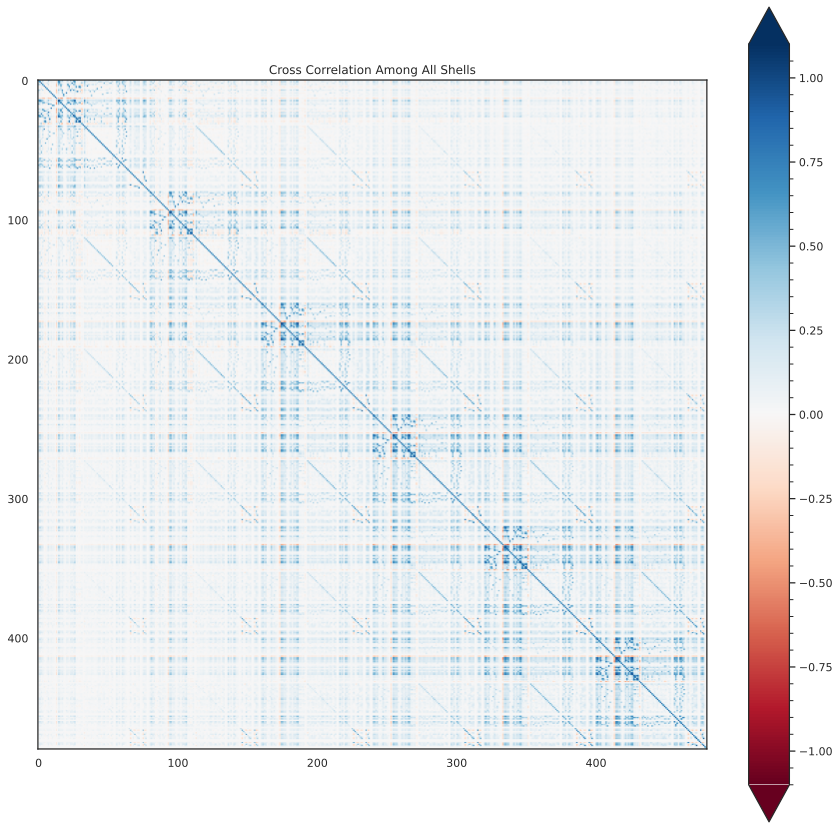

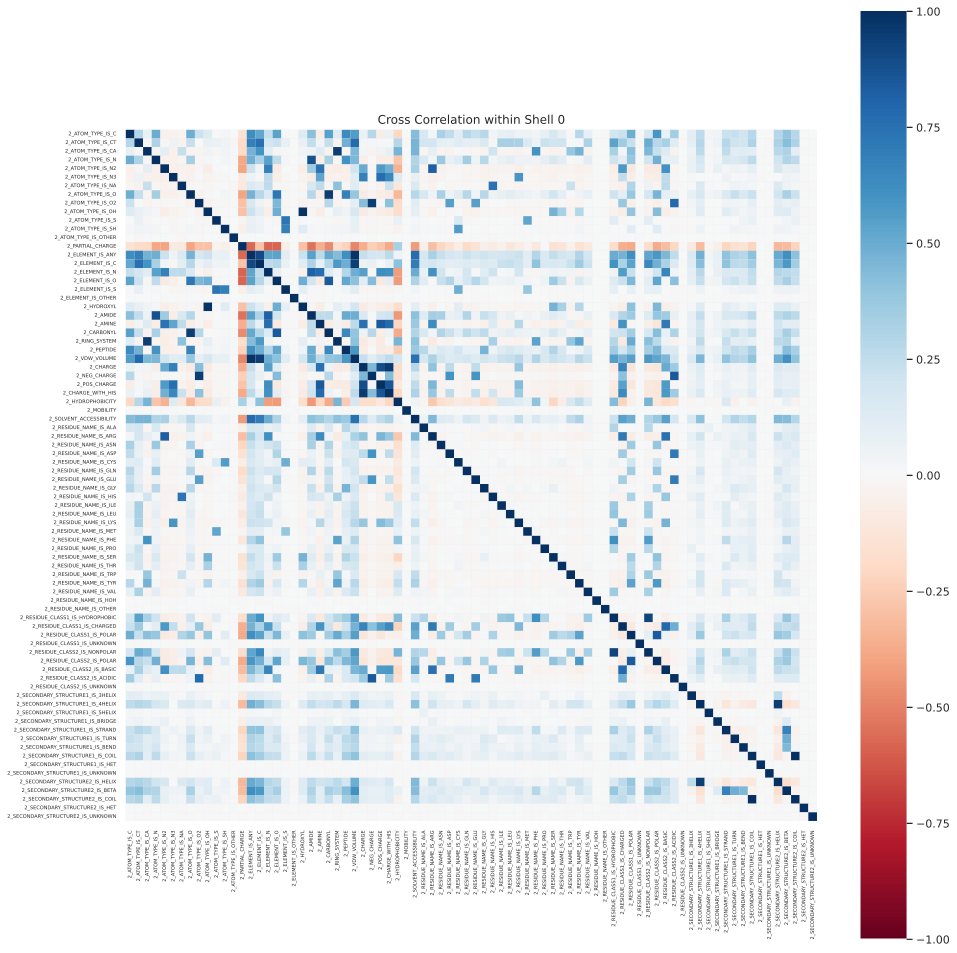

/tmp/ipykernel_322413/2793324119.py:82: RuntimeWarning: invalid value encountered in true_divide
  gg = sns.heatmap(np.nan_to_num(IPCA.mean_.reshape((6,80)).T / IPCA.var_.reshape((6,80)).T,nan = 0.0),


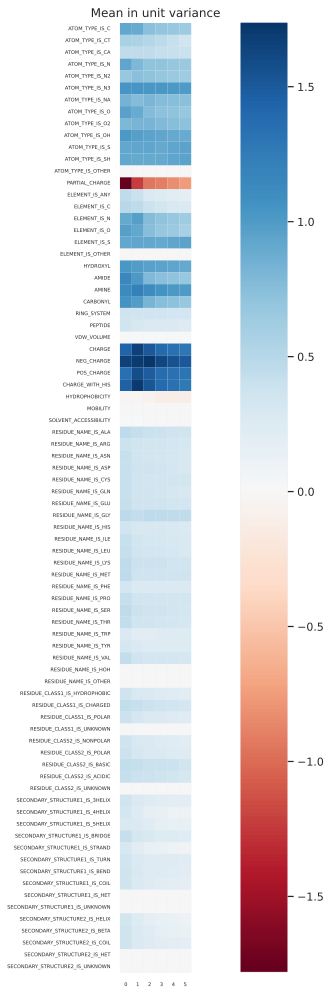

In [38]:
import numpy as np
import seaborn as sns
sns.set_theme(style='white')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import pickle
import pandas as pd


# =================
# Altman meanings
# ==================
DIR_AltmanFolder = "../NucleicNet/util/feature-3.1.0/"
altman_propnamelist=[]
propfile = open("%s/data/%s"%(DIR_AltmanFolder,"proteins.properties"), 'r')
propdata = propfile.read().splitlines()
for line in propdata:
    if line:
        if not line.startswith("#"):
            altman_propnamelist.append(str(line))
propfile.close()
shell_propname = []
for shell in range(8)[2:]: # NOTE The default of altman feature has 6 shells
    for prop in altman_propnamelist:
        shell_propname.append("%s_%s" %(shell, prop))


# ==============
# IPCA result obtained before 
# ===============
# NOTE Comment out these two lines when custom IPCA is desired
with open("../Database-PDB/DerivedData/Feature.IPCA.altman.AUCG.pkl", "rb") as fn:
    IPCA = pickle.load(fn)


estimated_cov = IPCA.get_covariance()
overvar = np.diag(np.nan_to_num(1 / np.sqrt(np.diag(estimated_cov)), nan = 1.0, posinf = 1.0, neginf = 1.0))
estimated_corr = (overvar @ estimated_cov) @ overvar

#print(np.min(estimated_cov), np.max(estimated_cov))
#print(estimated_corr)
#print(np.min(estimated_corr), np.max(estimated_corr))

# ==============
# Overall
# ===============
plt.figure(figsize = (15,15))
im6 = plt.imshow(estimated_corr,  cmap='RdBu', vmin=-1.1, vmax=1.1)
ax6 = plt.gca()
cbar = ax6.figure.colorbar(im6, ax=ax6, extend='both')
cbar.minorticks_on()
plt.title("Cross Correlation Among All Shells")
plt.show()


sns.set(rc = {'figure.figsize':(14,14)})
labels = [str(i) for i in shell_propname[:80]]
gg = sns.heatmap(estimated_corr[:80,:80], vmin=-1., vmax=1.0, cmap='RdBu', center=0.0, 
            linewidths=0, cbar=True,xticklabels=labels, yticklabels=labels, square = True)
gg.set_xticklabels(gg.get_xmajorticklabels(), fontsize = 5)
gg.set_yticklabels(gg.get_ymajorticklabels(), fontsize = 5)
plt.title("Cross Correlation within Shell 0")
plt.tight_layout()
plt.show()

from matplotlib import colors
#print(IPCA.components_.shape)






# ==============
# Mean / variance
# ===============


sns.set(rc = {'figure.figsize':(14,14)})
labels = [str(i)[2:] for i in shell_propname[:80]]
gg = sns.heatmap(np.nan_to_num(IPCA.mean_.reshape((6,80)).T / IPCA.var_.reshape((6,80)).T,nan = 0.0), 
            #vmin=-1., vmax=1.0, 
            cmap='RdBu', center=0.0, 
            linewidths=0, cbar=True,xticklabels=[ii for ii in range(6)], yticklabels=labels, square = True)
gg.set_xticklabels(gg.get_xmajorticklabels(), fontsize = 5)
gg.set_yticklabels(gg.get_ymajorticklabels(), fontsize = 5)
plt.title("Mean in unit variance")
plt.tight_layout()
plt.show()

## Epilogue
In this Notebook, we looked into some basic statistics of the Altman features. An important side note here is that while the dimensionality reduction by PCA will alleviate memory demand, we find this strategy of linearising the features will tradeoff accuracy by quite a lot, so likely you may not want to do it.